_this notebook is meant to execute **`R`** in a `conda` environment_

# Introduction



In this third Notebook on *higher order* **_Trend Surface analysis with R_** we introduce;

<ol type = "1">
    <li>General Additive Models (GAM) and </li>
    <li>Thin plate splines</li>
</ol>


<div class="alert alert-block alert-danger"><b>REQUIRED: </b></div>

**You are required to insert your outputs and any comment into this document.**

The document you submit should therefore contain the existing text in addition to:

> *   Plots and other outputs from executing the code chunks  
> *   Discussion of your plots and other outputs as well as conclusions reached.

This should also include any hypotheses and assumptions made as well as factors that may affect your conclusions.

## 1. General Additive Models (GAM)

We now truly start our journey into higher order trend surface analysis. GAMs are very similar to multiple `linear regression`; where each predictor  typically has a smooth function. The advantage is that GAMs can capture intricate and complex patterns traditional `linear models` often miss.

The disadvantage of these methods are their computational complexity and the risk of overfitting. It is pretty dangerous to extrapolate outside the range of calibration (i.e.: beyond the observation points).

_please install necessary packages through a `prompt` interface; as per the [requirements.txt](https://github.com/AdrianKriger/APG3040C-APG4013C/blob/main/cptFlatsAquifer/requirements.txt) Not here_.

In [28]:
options(prompt="> ", continue="+ ", digits=3, width=70, show.signif.stars=T, repr.plot.width=6, repr.plot.height=6)
rm(list=ls())

# Install necessary packages: You only need to run this part once
##- install.packages(c("sf", "gstat", "ggplot2", "gridExtra","units", "terra","mgcv","fields","nlme"))

#library(repr)
library(sf) # 'simple features' representations of spatial objects
library(gstat) # geostatistics
library(ggplot2) # geostatistics
library(gridExtra)
library(units) # units of measure
library(terra) # gridded data structures ("rasters")
library(mgcv)
library(fields)

Warning message:
"package 'fields' was built under R version 3.6.3"Loading required package: viridis
Warning message:
"package 'viridis' was built under R version 3.6.3"Loading required package: viridisLite
Warning message:
"package 'viridisLite' was built under R version 3.6.3"See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 

Attaching package: 'fields'

The following object is masked from 'package:terra':

    describe



In [29]:
options(show.signif.stars=FALSE)

We've already covered creating a 500m grid and 2nd-order prediction and interpolation with previous Notebooks and move through the introduction quickly.

In [30]:
file = 'cptFlatsAquifer_watertable4.txt'

In [31]:
#-- import
cfaq <- read.csv(file, header = 1, sep = ',', dec = '.') #sep = '\t',
#- set crs
cfaq.sf <- st_as_sf(cfaq, coords=c("long", "lat"), crs = 4326) #wgs84
#- transform to local crs
cfaq.sf <- st_transform(cfaq.sf, crs = 32734) #utm 34s
cfaq$X <- st_coordinates(cfaq.sf)[, "X"]
cfaq$Y <- st_coordinates(cfaq.sf)[, "Y"]

model.ts2 <- lm(waterLevel ~ X + Y + I(X^2) + I(Y^2) + I(X*Y), data=drop_units(cfaq))

#--  create grid
#(n.col <- length(seq.e <- seq(min.x <- floor(min(st_coordinates(cfaq.sf)[,1])/1000)*1000,
#                              max.x <- ceiling(max(st_coordinates(cfaq.sf)[,1])/1000)*1000, by=1000)))
#(n.col <- length(seq.e <- seq(min.x <- floor(min(st_coordinates(cfaq.sf)[,2])/1000)*1000,
#                              max.x <- ceiling(max(st_coordinates(cfaq.sf)[,2])/1000)*1000, by=1000)))
(n.col <- length(seq.e <- seq(min.x <- floor(min(cfaq$X)/1000)*1000,
                              max.x <- ceiling(max(cfaq$X)/1000)*1000, by=1000)))
(n.row <- length(seq.n <- seq(min.y <- floor(min(cfaq$Y)/1000)*1000,
                              max.y <- ceiling(max(cfaq$Y)/1000)*1000, by=1000)))

#we want a XXXXm grid
grid <- rast(nrows = n.row, ncols = n.col,
             xmin=min.x, xmax=max.x,
             ymin=min.y, ymax=max.y, crs = st_crs(cfaq.sf)$proj4string,
             resolution = 500, names="waterLevel")

values(grid) <- NA_real_

grid.df <- as.data.frame(grid, xy = TRUE, na.rm = FALSE)
names(grid.df)[1:2] <- c("X", "Y") # match the names of the point dataset
summary(grid.df)

#--
pred.ts2 <- predict.lm(model.ts2,
                       newdata = grid.df,
                       interval = "prediction", level = 0.95)

#-- add the three prediction fields (fit, lower, upper) to the data
grid.df[, 3:5] <- pred.ts2
names(grid.df)[3:5] <- c("ts2.fit", "ts2.lwr", "ts2.upr")

[1] 21

[1] 22

       X                Y             waterLevel  
 Min.   :264250   Min.   :6227250   Min.   : NA   
 1st Qu.:269125   1st Qu.:6232250   1st Qu.: NA   
 Median :274000   Median :6237500   Median : NA   
 Mean   :274000   Mean   :6237500   Mean   :NaN   
 3rd Qu.:278875   3rd Qu.:6242750   3rd Qu.: NA   
 Max.   :283750   Max.   :6247750   Max.   : NA   
                                    NA's   :1680  

In [32]:
#-- look
head(cfaq ,3)

name,long,lat,waterLevel,elevation,depth,X,Y
EM_01,18.6,-34.1,14.4,20.4,63,274222,6227351
EM_27,18.6,-34.1,16.2,20.0,48,276191,6227571
EM_29,18.6,-34.1,18.8,25.5,39,279770,6229369


We start through first exploring whether a curve _(a smoothing function)_ better captures the relationships between location (x, y) and the aquifer water level. We do this through the local polynomial regression via the `leoss` function built into `ggplot2` as `geom_smooth`.

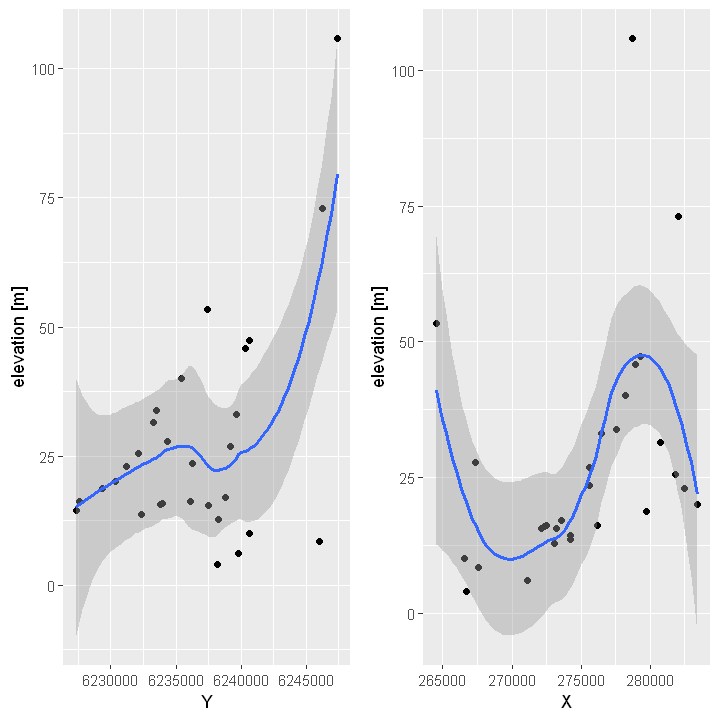

In [33]:
##- plot
g1 <- ggplot(drop_units(cfaq), aes(x=Y, y=waterLevel)) +
  geom_point() +
  geom_smooth(method="loess") +
  labs(y = "elevation [m]")
g2 <- ggplot(drop_units(cfaq), aes(x=X, y=waterLevel)) +
  geom_point() +
  geom_smooth(method="loess") +
  labs(y = "elevation [m]")
grid.arrange(g1, g2, ncol = 2)

<div class="alert alert-block alert-warning"><b>QUESTION: </b> </div>

- Do these marginal relations appear to be linear in the predictors?

> [double click in this cell and type your answer here]

**Fitting the GAM**

We work with the **Mixed GAM Computation Vehicle** `mgcv` library default smoothing setting and explore **thin plate splines**, as an alternate smoothing function later.

In [34]:
model.gam <- gam(waterLevel ~ s(X, Y, k = 29), data=drop_units(cfaq))
summary(model.gam)


Family: gaussian 
Link function: identity 

Formula:
waterLevel ~ s(X, Y, k = 29)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept) 27.42376    0.00135   20288        1

Approximate significance of smooth terms:
       edf Ref.df       F p-value
s(X,Y)  28     28 8806572       1

R-sq.(adj) =      1   Deviance explained =  100%
GCV = 13.833  Scale est. = 5.2987e-05  n = 29

<div class="alert alert-block alert-warning"><b>QUESTION: </b> </div>

- How well does this model fit the calibration observations?

> [double click in this cell and type your answer here]

**Since we have a 2nd-order trend surface; lets compare.**

we do this with numbers and graphs.

In [35]:
#- residuals
resid.gam <- residuals(model.gam)
summary(resid.gam)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-4.05e-05 -5.10e-06 -4.00e-07  0.00e+00  5.60e-06  2.90e-05 

In [36]:
summary(residuals(model.ts2))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -26.21   -3.82   -1.55    0.00    2.41   29.56 

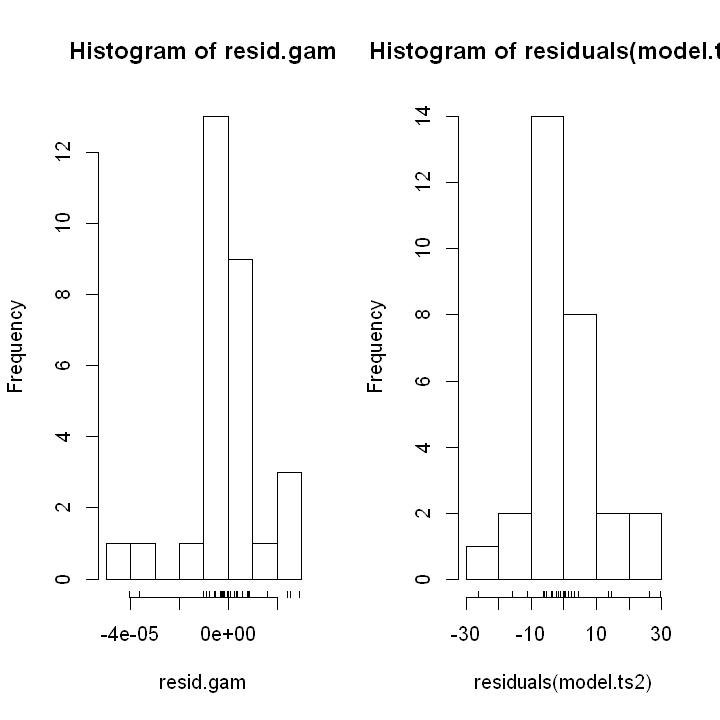

In [37]:
#regular histogram
par(mfrow=c(1,2))
hist(resid.gam)#, xlim=c(-5, 5))#,
     #breaks=c(min(cfaq$waterLevel), max(cfaq$waterLevel), by=2)), main="Residuals from GAM")
rug(residuals(model.gam))
hist(residuals(model.ts2))#, xlim=c(-30, 30))#,
     #breaks=c(min(cfaq$waterLevel), max(cfaq$waterLevel), by=2), main="Residuals from 2nd-order OLS trend")
rug(residuals(model.ts2))
par(mfrow=c(1,1))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


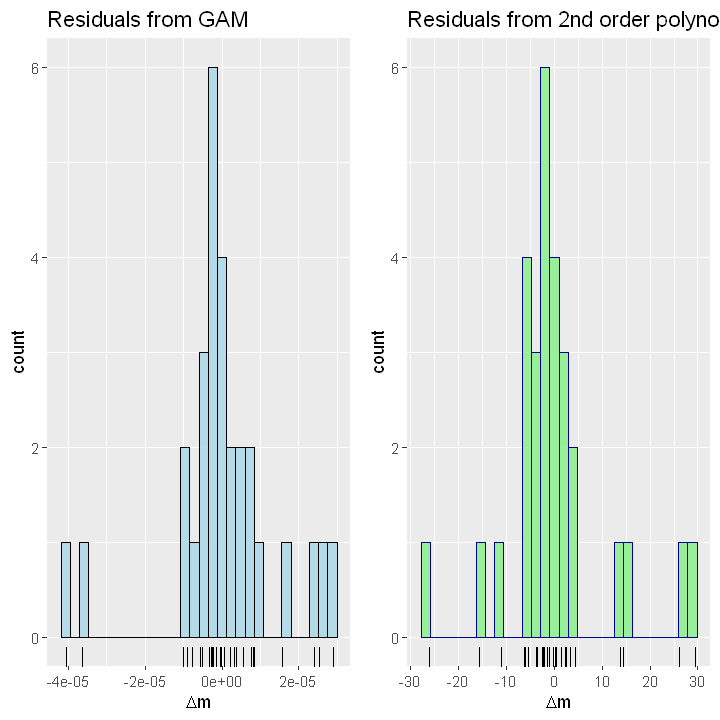

In [38]:
#-- ggplot2
g1 <- ggplot(data=as.data.frame(resid.gam), aes(resid.gam)) +
  geom_histogram(#breaks=seq(-20,20,by=2),
                 fill="lightblue", color="black", alpha=0.9) +
  geom_rug() +
  labs(title = "Residuals from GAM",
       x = expression(paste(Delta, m)))
g2 <- ggplot(data=as.data.frame(residuals(model.ts2)), aes(residuals(model.ts2))) +
  geom_histogram(#breaks=seq(-20,20,by=2),
                 fill="lightgreen", color="darkblue", alpha=0.9) +
  geom_rug() +
  labs(title = "Residuals from 2nd order polynomial trend surface",
       x = expression(paste(Delta, m)))
grid.arrange(g1, g2, nrow=1)

<div class="alert alert-block alert-warning"><b>QUESTION: </b> </div>

- Which histogram shows the narrowest spread?

> [double click in this cell and type your answer here]

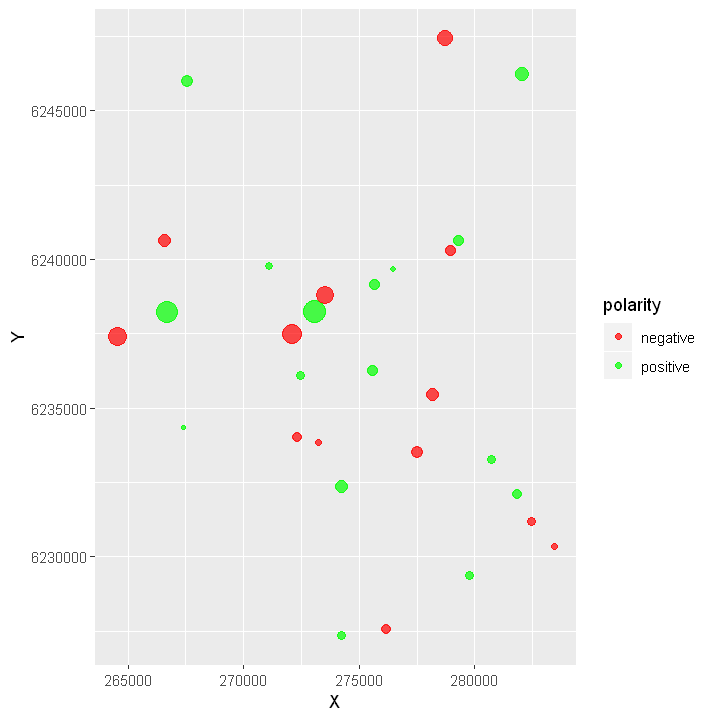

In [39]:
#-- residuals as a bubble plot. show the size of the residuals by the size of a point, and the polarity (positive vs. negative)
cfaq$resid.gam <- resid.gam
ggplot(data = drop_units(cfaq)) +
  aes(x=X, y=Y, size = abs(resid.gam),
      col = ifelse((resid.gam < 0), "red", "green")) +
  geom_point(alpha=0.7) +
  scale_size_continuous(name = expression(paste(plain("residual ["),
                                                reDelta, m, plain("]"))),
                        breaks=seq(0,12, by=2)) +
  scale_color_manual(name = "polarity",
                     labels = c("negative","positive"),
                     values = c("red","green","blue"))

<div class="alert alert-block alert-warning"><b>QUESTION: </b> </div>

- Does there appear to be any local spatial correlation of the residuals?

> [double click in this cell and type your answer here]

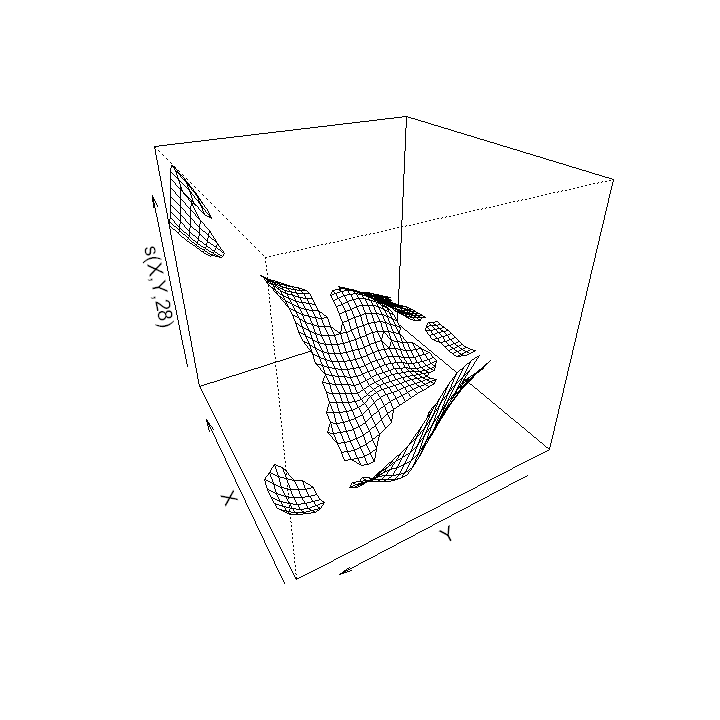

In [40]:
#- gam as 3D surface
plot.gam(model.gam, rug = FALSE, se = FALSE, select=1,
         scheme=1, theta=110+130, phi=30)

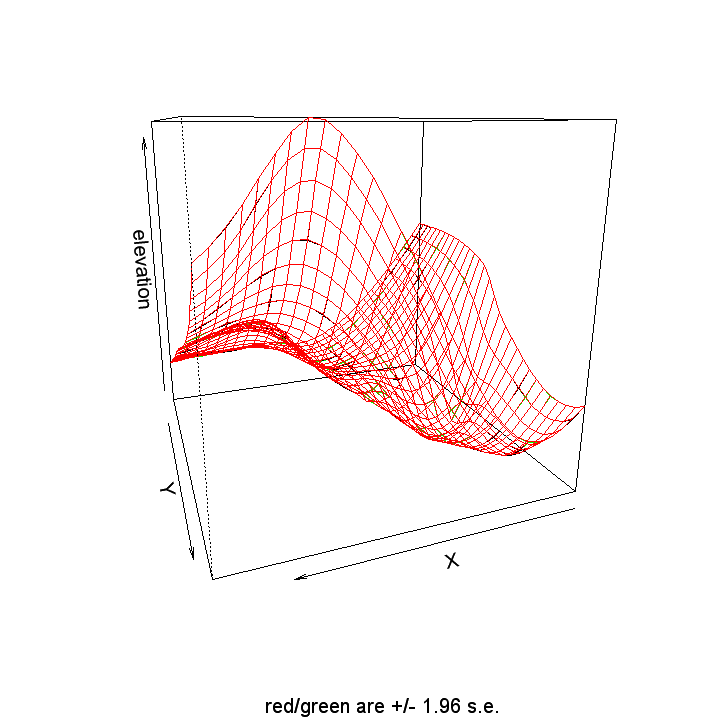

In [41]:
#-3D with 1 standard error of fit
vis.gam(model.gam, plot.type="persp", color="terrain",
        theta=160, zlab="elevation", se=1.96)

**GAM `RMSE`and predict the model onto our 500m grid**

In [42]:
#-- rmse
(rmse.gam <- sqrt(sum(residuals(model.gam)^2)/length(residuals(model.gam))))

[1] 1.43e-05

<div class="alert alert-block alert-warning"><b>QUESTION: </b> </div>

- Is the RMSE reasonable?

> [double click in this cell and type your answer here]

In [43]:
#-- predict aquifer elevation, standard error of prediction using the fitted GAM
tmp <- predict.gam(object=model.gam,
                   newdata=grid.df,
                   se.fit=TRUE)
summary(tmp$fit)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   -3.2    16.1    26.6    32.3    43.9   107.8 

In [44]:
summary(tmp$se.fit)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00471 0.00643 0.00745 0.00789 0.00864 0.01614 

In [45]:
str(tmp)

List of 2
 $ fit   : num [1:1680(1d)] 27.7 25.1 22.7 20.9 19.5 ...
  ..- attr(*, "dimnames")=List of 1
  .. ..$ : chr [1:1680] "1" "2" "3" "4" ...
 $ se.fit: num [1:1680(1d)] 0.01072 0.01036 0.01005 0.00978 0.00955 ...
  ..- attr(*, "dimnames")=List of 1
  .. ..$ : chr [1:1680] "1" "2" "3" "4" ...


In [46]:
#-- add these to the data.frame of the spatial grid with the as.numeric(1d array to vector)
grid.df$pred.gam <- as.numeric(tmp$fit)
grid.df$pred.gam.se <- as.numeric(tmp$se.fit)

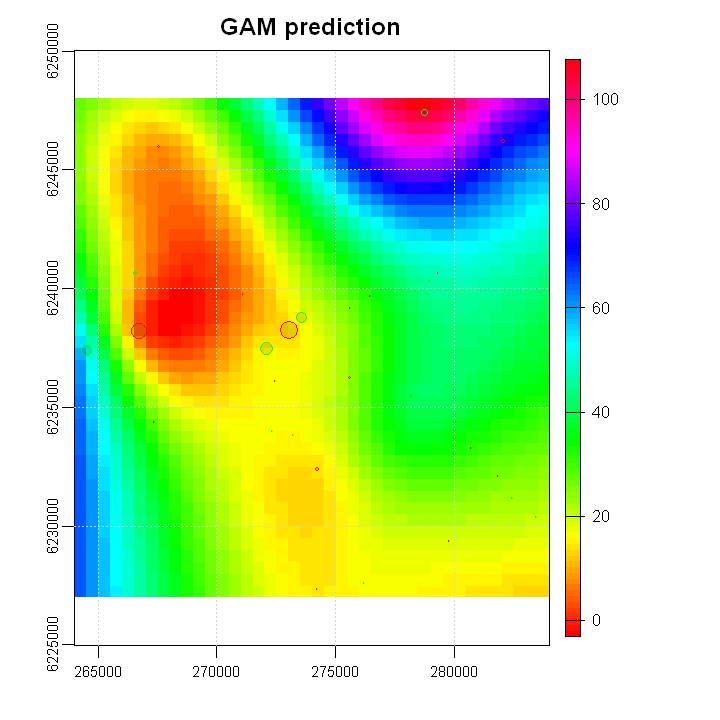

In [47]:
#-- plot
grid.gam <- grid
values(grid.gam) <- grid.df$pred.gam
plot(grid.gam, col = rainbow(100), main="GAM prediction"); grid()
points(st_coordinates(cfaq.sf)[,2] ~ st_coordinates(cfaq.sf)[,1],
#       pch=16,
       col=ifelse(cfaq$resid.gam < 0, "red", "green"),
       cex=2*abs(cfaq$resid.gam)/max(abs(cfaq$resid.gam)),
                                     pch=21,
                                     bg = adjustcolor("black", alpha.f = 0.1),
                                     #col = "black",
                                     #cex = 0.9,
                                     lwd = 0.5)

<div class="alert alert-block alert-warning"><b>QUESTION: </b> </div>

-  How well does the GAM trend surface fit the points? Are there obvious problems?

> [double click in this cell and type your answer here]

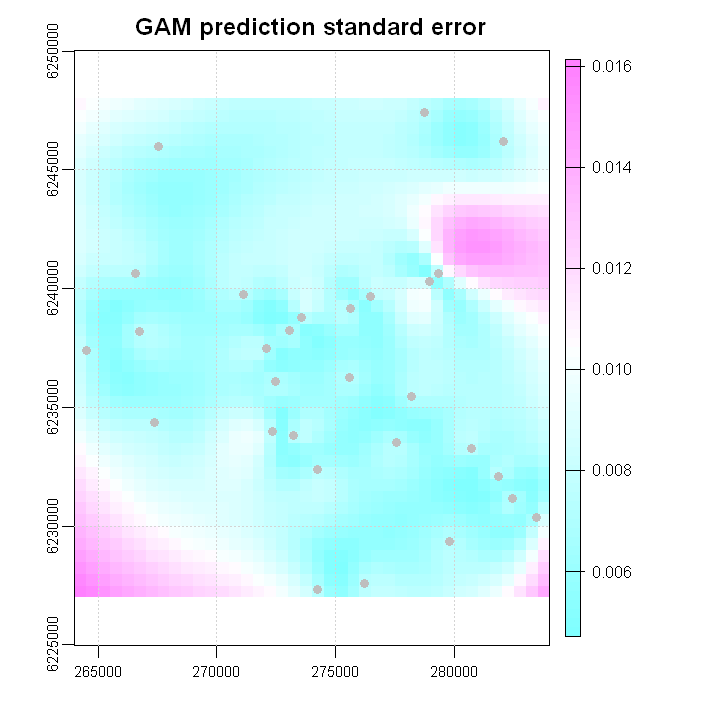

In [48]:
#- standard errors of prediction
grid.gam.se <- grid
values(grid.gam.se) <- grid.df$pred.gam.se
plot(grid.gam.se, main="GAM prediction standard error",
     col=cm.colors(64))
grid()
points(st_coordinates(cfaq.sf)[,2] ~ st_coordinates(cfaq.sf)[,1], pch=16,
       col="grey")

We see our GAM standard errors follow a similar pattern to the polynomial surfaces with concentrations higher along the edges but what we really want to know is where the GAM surface differs from the traditional parametric

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  -50.8    -6.6    -0.7    -0.2     6.5    37.0 

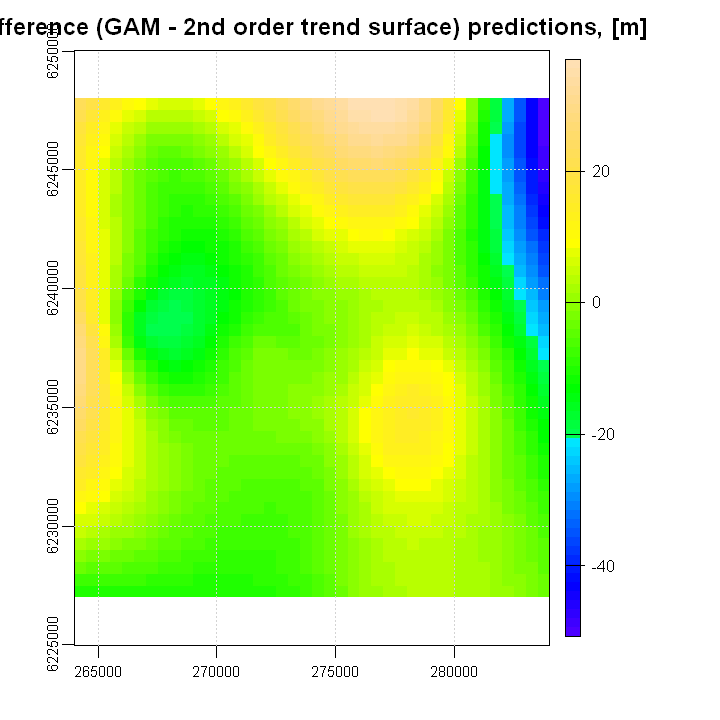

In [49]:
summary(grid.df$diff.gam.ols <- grid.df$pred.gam - grid.df$ts2.fit)

grid.diff.gam.ols <- grid
values(grid.diff.gam.ols) <- grid.df$diff.gam.ols
plot(grid.diff.gam.ols,
     main="Difference (GAM - 2nd order trend surface) predictions, [m]",
     col=topo.colors(64))
grid()

Here the positive differences are where the GAM predicts higher values than
the trend surface.

<div class="alert alert-block alert-warning"><b>QUESTION: </b> </div>

- Where are the largest differences between the GAM and 2nd order OLS trend surface predictions? Explain why, considering how the two surfaces are computed

> [double click in this cell and type your answer here]

## 2. Thin-plate spline interpolation

Thin-plate splines are equivalent to a _thin and flexible_ plate warped to fit a dataset. We can do this with a single _plane_ surface similar to a 1st-degree polynomial all the way through to an extremely supple surface that perfectly fit every observation.

Generally we choose a balanced approach because overfitting introduces noise.

In [50]:
#-- set up thin plate spline
cfaq.tps <- cfaq[, c("X","Y", "waterLevel")]
cfaq.tps$coords <- matrix(c(cfaq.tps$X, cfaq.tps$Y), byrow=F, ncol=2)
str(cfaq.tps$coords)

 num [1:29, 1:2] 274222 276191 279770 283452 282454 ...


In [51]:
surf.1 <- fields::Tps(cfaq.tps$coords, cfaq.tps$waterLevel)

Grid searches over lambda (nugget and sill variances) with  minima at the endpoints: 
  (GCV) Generalized Cross-Validation 
   minimum at  right endpoint  lambda  =  2.15e-05 (eff. df= 27.5 )


In [52]:
summary(surf.1)

CALL:
fields::Tps(x = cfaq.tps$coords, Y = cfaq.tps$waterLevel)
                                                 
 Number of Observations:                29       
 Number of unique points:               29       
 Number of parameters in the null space 3        
 Parameters for fixed spatial drift     3        
 Effective degrees of freedom:          27.5     
 Residual degrees of freedom:           1.5      
 MLE tau                                1.15     
 GCV tau                                0.848    
 MLE sigma                              61000    
 Scale passed for covariance (sigma)    <NA>     
 Scale passed for nugget (tau^2)        <NA>     
 Smoothing parameter lambda             2.154e-05

Residual Summary:
    min   1st Q  median   3rd Q     max 
-0.5349 -0.0597 -0.0129  0.0589  0.3685 

Covariance Model: Rad.cov
  Names of non-default covariance arguments: 
       p

DETAILS ON SMOOTHING PARAMETER:
 Method used:   GCV    Cost:  1
   lambda       trA       GCV   GCV.on

In [53]:
#-- predict over the study area
grid.coords.m <- as.matrix(grid.df[, c("X", "Y")], ncol=2)
str(grid.coords.m)

 num [1:1680, 1:2] 264250 264750 265250 265750 266250 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:2] "X" "Y"


In [54]:
surf.1.pred <- predict.Krig(surf.1, grid.coords.m)
summary(grid.df$pred.tps <- as.numeric(surf.1.pred))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   -2.9    16.1    26.7    32.3    43.8   107.5 

In [55]:
#-- compute and summarize residuals
grid.tps <- grid
values(grid.tps) <- surf.1.pred
tmp <- extract(grid.tps, st_coordinates(cfaq.sf))
#names(tmp)

summary(cfaq.sf$resid.tps <- (cfaq$waterLevel - tmp$waterLevel))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  -1.55   -0.53   -0.01    0.06    0.26    3.88 

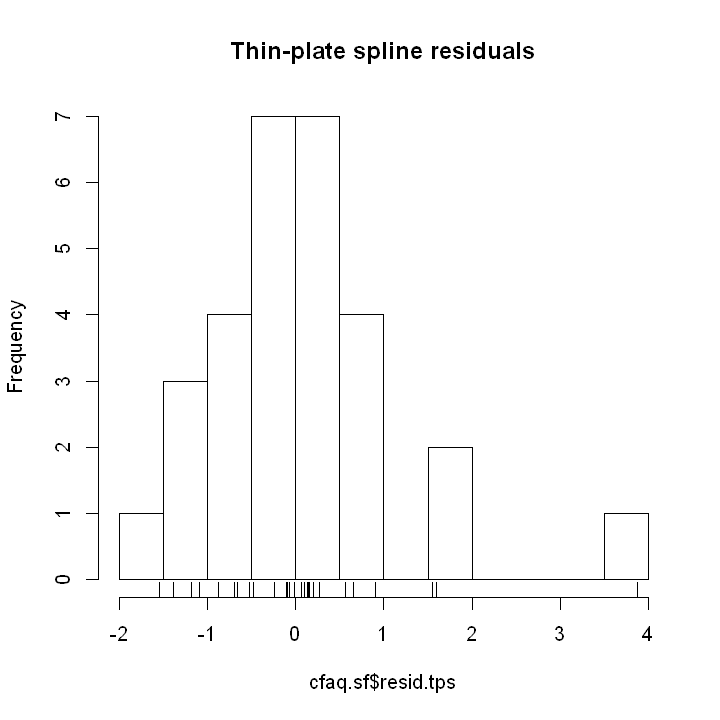

In [56]:
#- histogram of the residuals
hist(cfaq.sf$resid.tps, main="Thin-plate spline residuals", breaks=16)
rug(cfaq.sf$resid.tps)

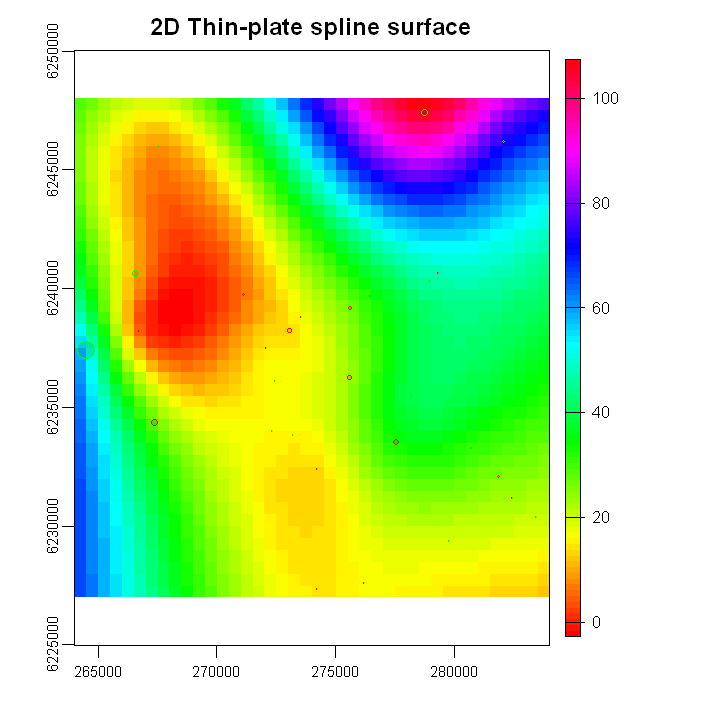

In [57]:
#- plot
plot(grid.tps, col = rainbow(100),
     main = "2D Thin-plate spline surface")
points(st_coordinates(cfaq.sf)[,2] ~ st_coordinates(cfaq.sf)[,1],
       #       pch=16,
       col=ifelse(cfaq.sf$resid.tps < 0, "red", "green"), #"black", "grey"),
       cex=2*abs(cfaq.sf$resid.tps)/max(abs(cfaq.sf$resid.tps)),
       pch=21,
       bg = adjustcolor("black", alpha.f = 0.1),
       #col = "black",
       #cex = 0.9,
       lwd = 0.5)

As with the other interpolation plots; the red and green illustrate positive and negative errors with size representative of magnitude. Notice how closely the surface fits the points.

Similarly; what we really want to know is where the thin-plate spline differs from the GAM surface.

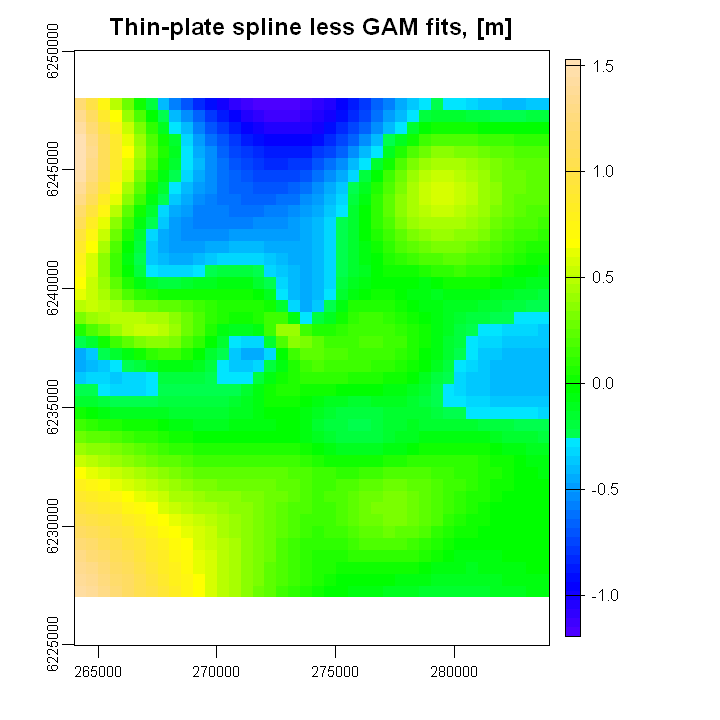

In [58]:
#- show the surface
grid.diff.tps.gam <- grid
grid.diff.tps.gam <- grid.tps - grid.gam
values(grid.diff.tps.gam) <- (values(grid.tps) - values(grid.gam))
plot(grid.diff.tps.gam,
     col = topo.colors(64),
     main = "Thin-plate spline less GAM fits, [m]",
     xlab = "X", ylab = "Y")

<div class="alert alert-block alert-success"> <b>A BREATHER</b>  </div>

Before we continue onto the next Notebook and Generalized Least Squares; we might want to take a break and possibly understand why we would want to go further than this pretty good surface!

One of the principles of Spatial Data Science is; **data is spatially autocorrelated**. Patterns and particularly residuals (errors) have a spatial structure / are connected.

In other words; ***"everything is related to everything else, but near things are more related than distant things"*** - [The First Law of Geography, according to Waldo Tobler](https://en.wikipedia.org/wiki/Tobler%27s_first_law_of_geography#cite_note-1)
>


We can model the spatial structure of residuals with a **variogram**; and then use this model to refine a trend surface with Generalized Least Squares.

Recall our formula for a 1st- (with more degrees of freedom for the  2nd-) order surface;

$$
    Z = 𝜷_0 + 𝜷_1x + 𝜷_2y + ϵ   
$$

In effect we do away with the broad $ϵ$ term _---applied to the entire study area---_ and introduce local terms to mininize the overall error  

In [61]:
#- emphirical variogram
cfaq$fit.ts2 <- fitted(model.ts2)
cfaq.sf$fit.ts2 <- fitted(model.ts2)
cfaq$res.ts2 <- residuals(model.ts2)
cfaq.sf$res.ts2 <- residuals(model.ts2)

The emphirical variogram can be characterised by

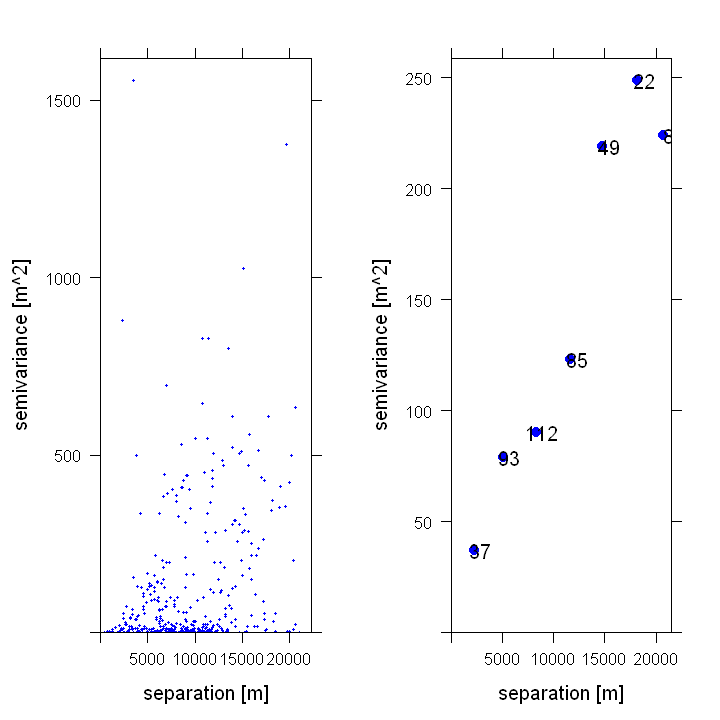

In [62]:
vr.c <- variogram(res.ts2 ~ 1, loc = cfaq.sf, cutoff = 50000, cloud = T)
vr <- variogram(res.ts2 ~ 1, loc = cfaq.sf, cutoff = 50000)
p1 <- plot(vr.c, col = "blue", pch = 20, cex = 0.5,
           xlab = "separation [m]", ylab = "semivariance [m^2]")
p2 <- plot(vr, plot.numbers = T, col = "blue", pch = 20, cex = 1.5,
           xlab = "separation [m]", ylab = "semivariance [m^2]")
print(p1, split = c(1,1,2,1), more = T)
print(p2, split = c(2,1,2,1), more = F)

<div class="alert alert-block alert-warning"><b>QUESTION: </b> </div>

- What are the estimated sill, range, and nugget of this variogram?

> [double click in this cell and type your answer here]